# Translating Hyperbolic Function: Postprocessing the DeepONet

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')

### Importing External Libraries

import numpy                             as np
import pandas                            as pd


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
import pyDOE
from PCAfold         import PCA          as PCAA


import romnet                            as rmnt

3.9.12 (main, Mar 26 2022, 15:51:13) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


## ODE

In [2]:
def fOrig(t, y):
    return [1./(np.cosh(Params[0]/Params[1]-t)**2)]

## Defining Input Variables

In [3]:
path_to_run_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/TransTanh_100Cases/DeepONet/Run_9/')
#path_to_run_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/TransTanh_100Cases/DeepONet/TestCase7_C/')

FigDir          = None #os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_TEMP/')

aParam          = 1.

TrainingCases   = [0]#[0,2,4,6,8]
TestCases       = [0,2,4]#[0,2]

NSamples        = 1

Nt              = 100
tout            = np.linspace(0.,15.,Nt)
SOLVER          = 'Radau'


ColorVec        = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']
LineVec         = ['-',':','--','.-']*10

## Loading ROMNet's Input Data File

In [4]:
print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData               = inputdata(WORKSPACE_PATH)


InputData.InputFilePath = path_to_run_fld+'/ROMNet_Input.py'
InputData.train_int_flg = 0
InputData.path_to_run_fld  = path_to_run_fld


[ROMNet]: Reading Input File from:  /Users/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/TransTanh/DeepONet/../../../../../../ROMNet/TransTanh_100Cases/DeepONet/Run_9/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


## Loading Tensorflow's Model for the Network 

In [5]:
surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.architecture, surrogate_type)

model = rmnt.model.Model_TF(InputData)

if (InputData.phys_system is not None):
    System = getattr(rmnt.pinn.system, InputData.phys_system)
    system = System(InputData)
    
model.build(InputData, None, Net, system)#, loadfile_no='000027')

NN    = model.net


[ROMNet - model_tf.py    ]:   Initializing the ML Model

[ROMNet - model_tf.py    ]:   Building the ML Model

[ROMNet - deeponet.py               ]:   Constructing Deep Operator Network: 
[ROMNet - system_of_components.py   ]:     Mapping Branch-to-Trunk (i.e., self.branch_to_trunk Object):  one_to_one
[ROMNet - system_of_components.py   ]:     Constructing System of Components: DeepONet
component_name =  Branch
[ROMNet - component.py              ]:       Constructing Component: Branch
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<keras.layers.core.dense.Dense object at 0x173c5af40>, <keras.layers.core.dropout.Dropout object at 0x173c5a250>, <keras.layers.core.dense.Dense object at 0x173c5a760>, <keras.layers.core.dropout.Dropout object at 0x173c5a8b0>, <keras.layers.core.dense.Dense object at 0x173d08ca0>, <keras.layers.core.dropout.Dropout object at 0x173d08220>, <keras.layers.core.dense.Dense object at 0x173d08a60>]

## Evaluating DeepONet on Test Data

In [6]:
input_vars  = model.net.input_vars
trunk_vars  = InputData.input_vars['DeepONet']['Trunk']
branch_vars = InputData.input_vars['DeepONet']['Branch']

FileName  = WORKSPACE_PATH + '/ROMNet/Data/TransTanh_100Cases/Orig/test/ext/Input.csv'# + InputData.InputFile
Data      = pd.read_csv(FileName, header=0)
Input     = Data[branch_vars].to_numpy()
VarNames  = list(Data.columns)
Nu        = Input.shape[1]
u         = []
for iu in range(Nu):
    u.append(np.unique(Input[:,iu]))
u         = np.stack(u, axis=0).T
u

array([[5.25],
       [5.75],
       [6.25],
       [6.75],
       [7.25],
       [7.75],
       [8.25],
       [8.75],
       [9.25],
       [9.75]])

iVar =  1
u0 =  [5.25]


/usr/local/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
/var/folders/09/5pnsdvfx78nbjmwff3_24d540000gp/T/ipykernel_36717/3414112267.py:2: RuntimeWarning: overflow encountered in double_scalars
  return [1./(np.cosh(Params[0]/Params[1]-t)**2)]


u0 =  [5.75]


/usr/local/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
/var/folders/09/5pnsdvfx78nbjmwff3_24d540000gp/T/ipykernel_36717/3414112267.py:2: RuntimeWarning: overflow encountered in cosh
  return [1./(np.cosh(Params[0]/Params[1]-t)**2)]


u0 =  [6.25]


/usr/local/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
/var/folders/09/5pnsdvfx78nbjmwff3_24d540000gp/T/ipykernel_36717/3414112267.py:2: RuntimeWarning: overflow encountered in cosh
  return [1./(np.cosh(Params[0]/Params[1]-t)**2)]


u0 =  [6.75]


/usr/local/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
/var/folders/09/5pnsdvfx78nbjmwff3_24d540000gp/T/ipykernel_36717/3414112267.py:2: RuntimeWarning: overflow encountered in cosh
  return [1./(np.cosh(Params[0]/Params[1]-t)**2)]


u0 =  [7.25]


/usr/local/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
/var/folders/09/5pnsdvfx78nbjmwff3_24d540000gp/T/ipykernel_36717/3414112267.py:2: RuntimeWarning: overflow encountered in cosh
  return [1./(np.cosh(Params[0]/Params[1]-t)**2)]


u0 =  [7.75]


/usr/local/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
/var/folders/09/5pnsdvfx78nbjmwff3_24d540000gp/T/ipykernel_36717/3414112267.py:2: RuntimeWarning: overflow encountered in cosh
  return [1./(np.cosh(Params[0]/Params[1]-t)**2)]


u0 =  [8.25]


/usr/local/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
/var/folders/09/5pnsdvfx78nbjmwff3_24d540000gp/T/ipykernel_36717/3414112267.py:2: RuntimeWarning: overflow encountered in cosh
  return [1./(np.cosh(Params[0]/Params[1]-t)**2)]


u0 =  [8.75]


/usr/local/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
/var/folders/09/5pnsdvfx78nbjmwff3_24d540000gp/T/ipykernel_36717/3414112267.py:2: RuntimeWarning: overflow encountered in cosh
  return [1./(np.cosh(Params[0]/Params[1]-t)**2)]


u0 =  [9.25]


/usr/local/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
/var/folders/09/5pnsdvfx78nbjmwff3_24d540000gp/T/ipykernel_36717/3414112267.py:2: RuntimeWarning: overflow encountered in cosh
  return [1./(np.cosh(Params[0]/Params[1]-t)**2)]


u0 =  [9.75]


/usr/local/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))
/var/folders/09/5pnsdvfx78nbjmwff3_24d540000gp/T/ipykernel_36717/3414112267.py:2: RuntimeWarning: overflow encountered in cosh
  return [1./(np.cosh(Params[0]/Params[1]-t)**2)]


Mean Squared Error =  [1.42544221e-06]
Root Mean Squared Error =  [0.00119392]


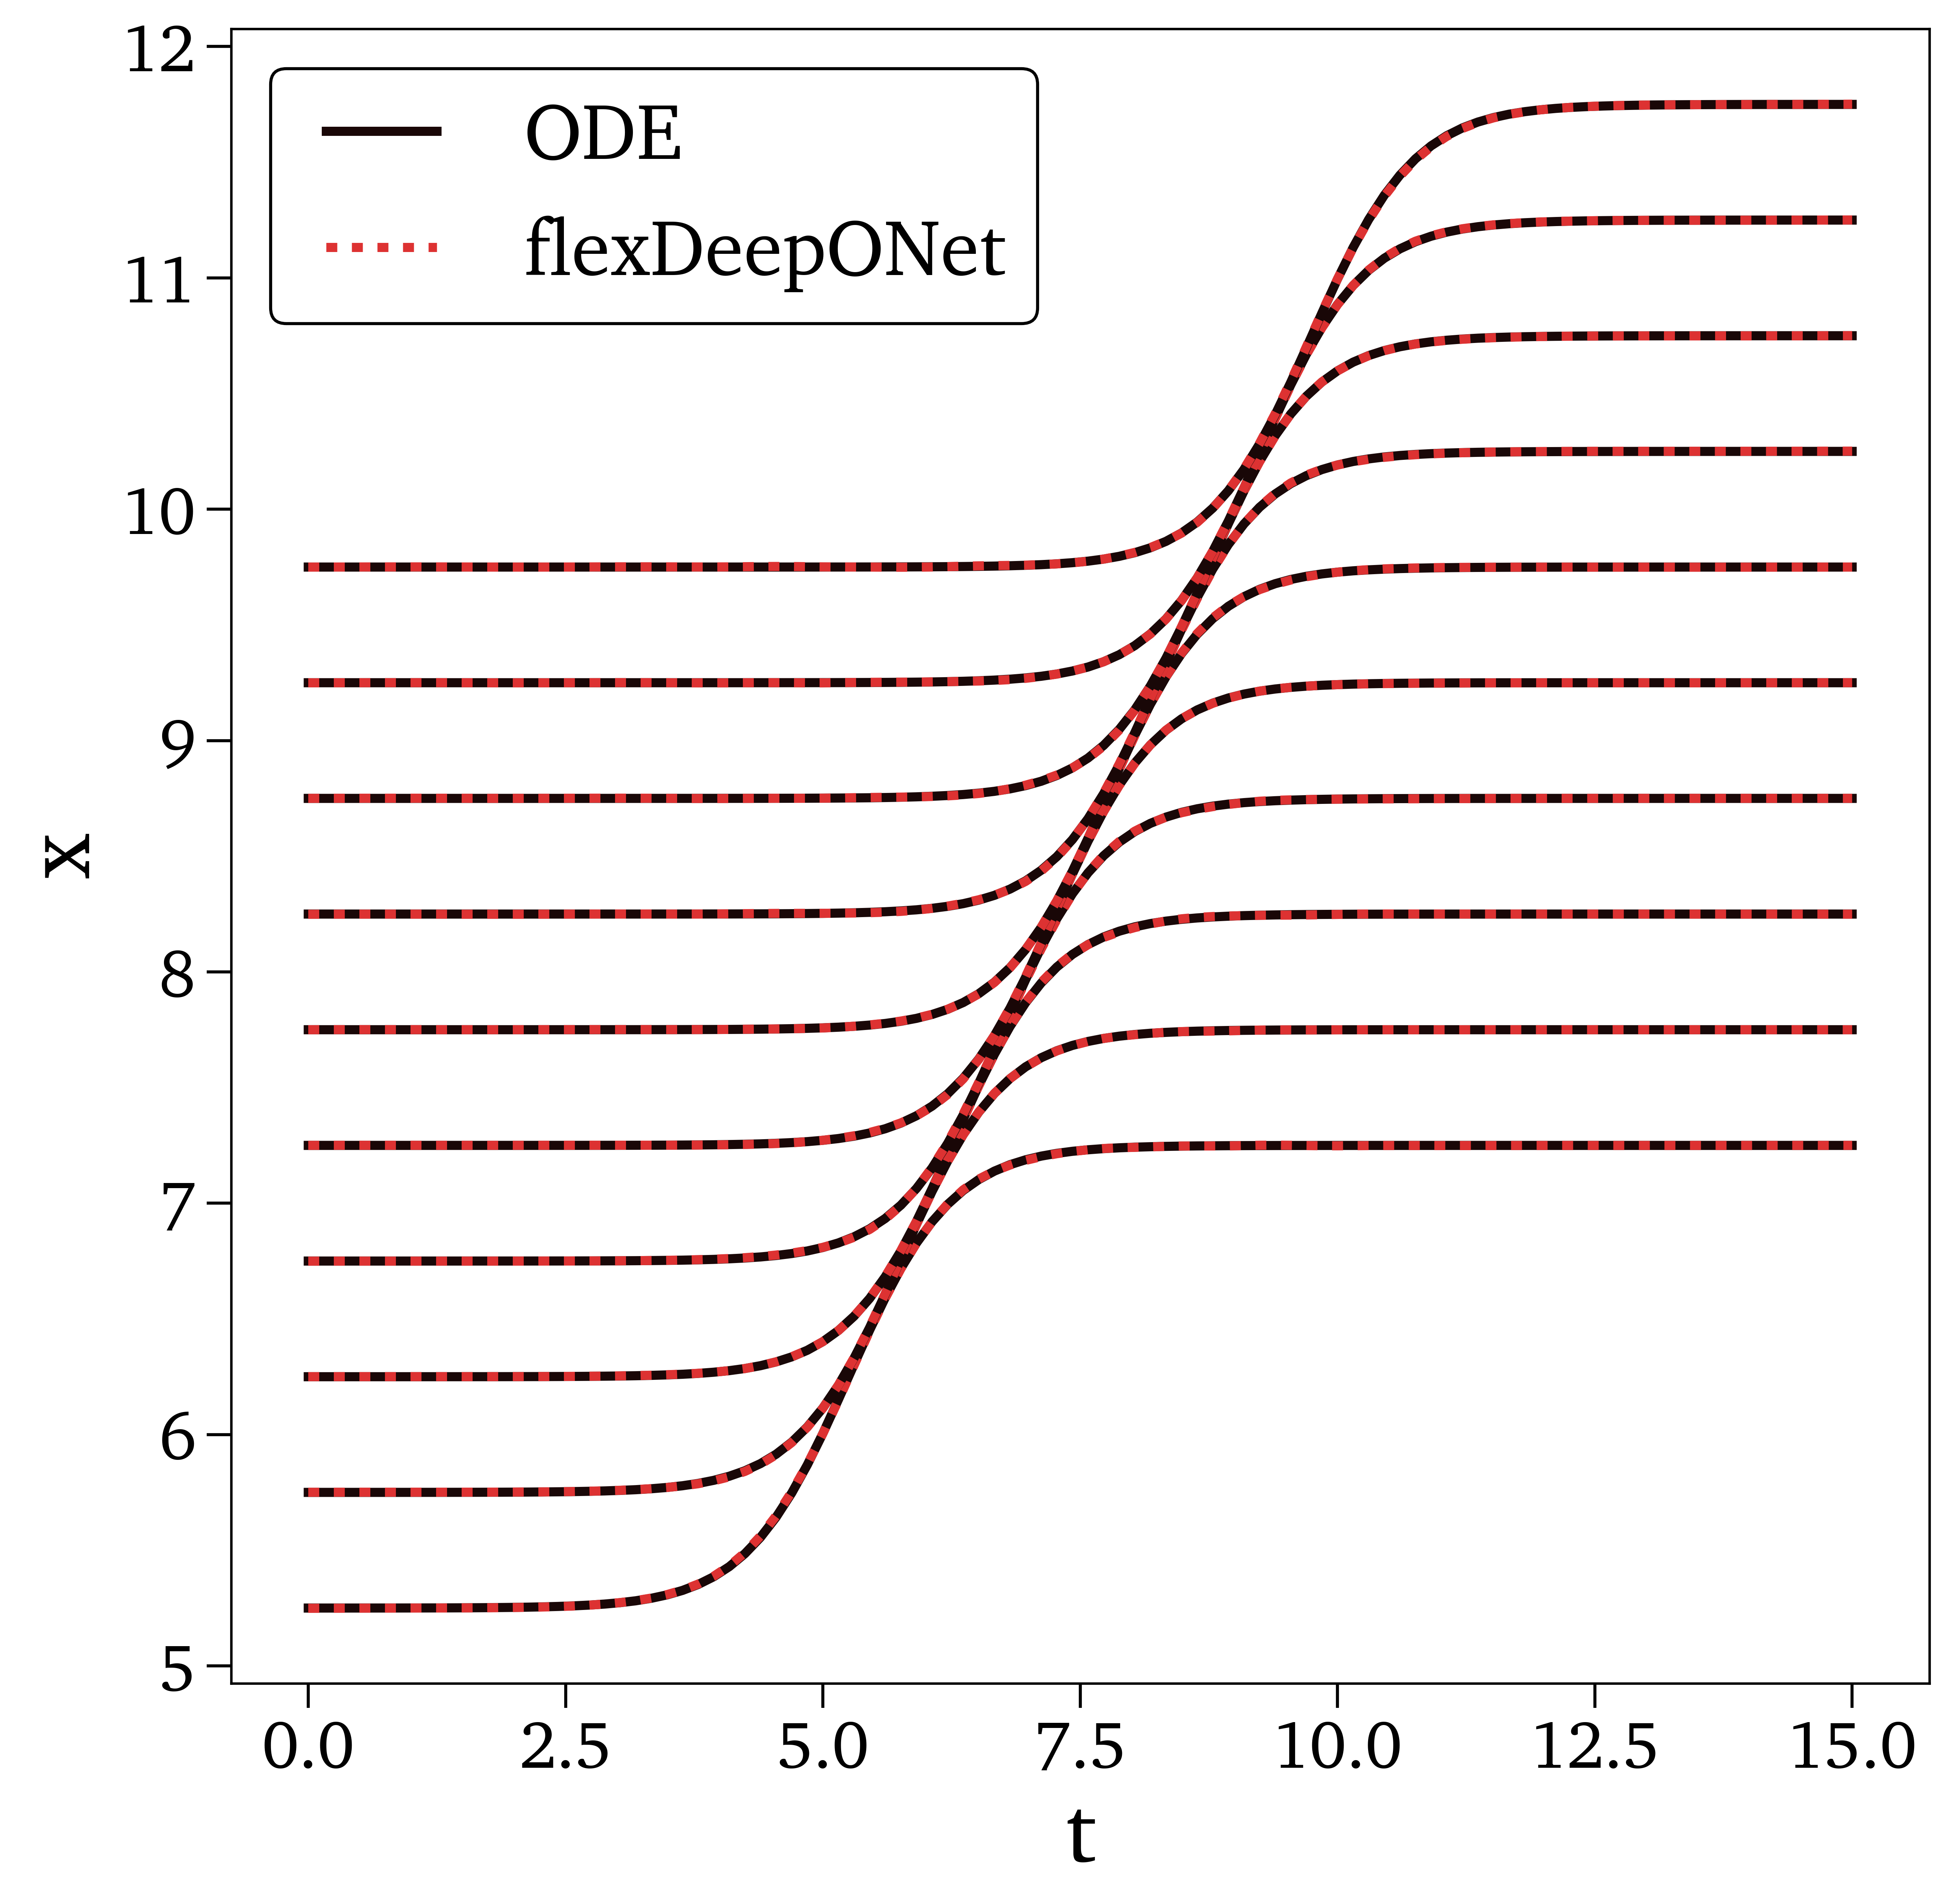

In [7]:
FileName  = WORKSPACE_PATH + '/ROMNet/Data/TransTanh_100Cases/Orig/test/ext/Input.csv'# + InputData.InputFile
Data      = pd.read_csv(FileName, header=0)
Input     = Data[branch_vars].to_numpy()
VarNames  = list(Data.columns)
Nu        = Input.shape[1]
u         = []
for iu in range(Nu):
    u.append(np.unique(Input[:,iu]))
u         = np.stack(u, axis=0).T


## Variable to Be Visualized
VarOI     = 'x'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break
    
Params = np.zeros(2)
iSim   = 0
for iTest in np.arange(0,10,1):
    y0         = u[iTest,:]
    #print('y0 = ', y0)
    Params[0]  = u[iTest,:]
    Params[1]  = aParam
    
    print('u0 = ', u[iTest,:])

    ### Generating Data  
    output     = solve_ivp( fOrig, tout[[0,-1]], u[iTest,:], method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
    tOrig      = tout
    yMatOrig   = output.y.T
    
    ### Creating NN Input
    tPred     = tOrig[...,np.newaxis]
    Nt        = len(tPred)
    uPred     = u[iTest,:]*np.ones((Nt,1))
    InputPred = np.concatenate((uPred,tPred), axis=1)
    
    if (InputData.surrogate_type == 'DeepONet') or (NSamples == 1):
        
        yMat      = model.predict(InputPred) 
        
        tLoop         = np.linspace(0.,15.,5)
        yMatLoop      = np.zeros((len(tLoop),1))
        InputPredLoop = np.concatenate([uPred[0,:][np.newaxis,...], (tLoop[0])[np.newaxis,np.newaxis]], axis=1)
        yMatLoop[0,:] = model.predict(InputPredLoop)
        for it, tLoop_ in enumerate(tLoop[1:]):
            InputPredLoop    = np.concatenate([yMatLoop[it,:][np.newaxis,...], (tLoop[it+1]-tLoop[it])[np.newaxis,np.newaxis]], axis=1)
            yMatLoop[it+1,:] = model.predict(InputPredLoop)
        
        ## Plotting
        
        if (iSim == 0):
            Label1 = 'ODE'
            #Label2 = r'DeepONet, $p='+str(InputData.n_modes)+'$'
            Label2 = 'flexDeepONet'
            Label3 = 'DeepONet, Iterative'
        else:
            Label1 = None
            Label2 = None
            Label3 = None
    
        plt.plot(tOrig, yMatOrig[:,iVar-1], '-', color=ColorVec[0], label=Label1)
        plt.plot(tPred, yMat[:,iVar-1],     ':', color=ColorVec[1], label=Label2)
        #plt.plot(tLoop, yMatLoop[:,iVar-1],  'ob', label=Label3)
        plt.xlabel(r'$t$')
        plt.ylabel(r'$x$')
        plt.legend()
        #plt.show()
        
        if (iSim == 0):   
            MSE  = (yMat[1::] - yMatOrig[1::])**2 #/y_Data[1::]**2
        else:
            MSE += (yMat[1::] - yMatOrig[1::])**2 #/y_Data[1::]**2

        
    else:

        ### Sampling NN
        yMat_sum = np.zeros((yMatOrig.shape[0], yMatOrig.shape[1]))
        yMat_sqr = np.zeros((yMatOrig.shape[0], yMatOrig.shape[1]))

        for iSample in range(NSamples):
            yMat_ = NN.predict(InputPred)    
            yMat_sum += yMat_
            yMat_sqr += yMat_**2

        yMat_mean = yMat_sum/NSamples
        yMat_std  = np.sqrt( yMat_sqr/NSamples - yMat_mean**2 )
        yMat_p1   = yMat_mean + 1.*yMat_std
        yMat_m1   = yMat_mean - 1.*yMat_std
        yMat_p2   = yMat_mean + 2.*yMat_std
        yMat_m2   = yMat_mean - 2.*yMat_std
        yMat_p3   = yMat_mean + 3.*yMat_std
        yMat_m3   = yMat_mean - 3.*yMat_std


        ## Plotting
        fig = plt.figure(figsize=(16, 12))
        plt.plot(tOrig, yMatOrig[:,iVar-1],  'k-', label='Data')
        plt.plot(tPred, yMat_mean[:,iVar-1], 'b-', label=r'DeepONet, $\mu$')
        plt.plot(tPred, yMat_p3[:,iVar-1],   'b:', label=r'DeepONet, $\mu+3\sigma$')
        plt.plot(tPred, yMat_m3[:,iVar-1],   'b:', label=r'DeepONet, $\mu-3\sigma$')
        plt.xlabel(r'$t$ [s]')
        plt.ylabel(r'$x$ [m]')
        plt.legend()
        plt.show()
        
    iSim += 1

if (FigDir):
    #plt.savefig(FigDir+'/TransTanh_TrainedDynamics_DeepONet_'+str(InputData.n_modes)+'.eps', format='eps', bbox_inches='tight')
    plt.savefig(FigDir+'/TransTanh_TrainedDynamics_flexDeepONet_'+str(InputData.n_modes)+'.eps', format='eps', bbox_inches='tight')
    pass


MSE_ = MSE.sum(axis=0) / iSim / (MSE.shape[0])
print('Mean Squared Error = ', MSE_)


RMSE = np.sqrt( MSE.sum(axis=0) / (iSim * MSE.shape[0]) )
print('Root Mean Squared Error = ', RMSE)

In [8]:
### Experimenting

# FileName  = WORKSPACE_PATH + '/ROMNet/Data/MSD_100Cases/Orig/test/ext/Input.csv'# + InputData.InputFile
# Data      = pd.read_csv(FileName, header=0)
# Input     = Data[branch_vars].to_numpy()
# VarNames  = list(Data.columns)
# Nu        = Input.shape[1]
# u         = []
# for iu in range(Nu):
#     u.append(np.unique(Input[:,iu]))
# u         = np.stack(u, axis=0).T

In [9]:
# CostVec_Int = []

# iSim = 0
# for iTest in [0,1,2,3,4]:
    
#     print('u0 = ', u[iTest,:])
    
#     t0 = time.time()
#     ### Generating Data  
#     output     = solve_ivp( fOrig, tout[[0,-1]], u[iTest,:], method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
#     t1 = time.time()
#     CostVec_Int.append(t1-t0)
    

#     iSim += 1

In [10]:
# CostVec_Loop = []

# iTestVec     = [0,1,2,3,4]

# tLoop        = np.linspace(0.,15.,3)

# iSim = 0
# for iTest in iTestVec:
    
#     print('u0 = ', u[iTest,:])
    
#     t0 = time.time()
#     yMatLoop      = np.zeros((len(tLoop),1))
#     InputPredLoop = np.concatenate([u[iTest,:][np.newaxis,...], (tLoop[0])[np.newaxis,np.newaxis]], axis=1)
#     yMatLoop[0,:] = model.net.predict(InputPredLoop)
#     for it, tLoop_ in enumerate(tLoop[1:]):
#         InputPredLoop    = np.concatenate([yMatLoop[it,:][np.newaxis,...], (tLoop[it+1]-tout[it])[np.newaxis,np.newaxis]], axis=1)
#         yMatLoop[it+1,:] = model.net.predict(InputPredLoop)

#     t1 = time.time()
#     CostVec_Loop.append(t1-t0)
    
#     plt.plot(tLoop, yMatLoop[:,iVar-1], 'b')
#     plt.xlabel('t')
#     plt.ylabel(VarOI)
#     plt.legend()
#     #plt.show()
    
#     iSim += 1

In [11]:
# Cost_Loop     = 0.

# iTestVec      = [0,1,2,3,4]*10
# n_test         = len(iTestVec)
    


# InputPredLoop = np.concatenate([u[iTestVec,:], np.array([tLoop[0]]*n_test)[...,np.newaxis]], axis=1)
# yMatLoop      = model.net.predict(InputPredLoop)
# yMatLoopAll   = []
# for it, tLoop_ in enumerate(tLoop[1:]):
#     InputPredLoop = np.concatenate([yMatLoop, np.array([tLoop[it+1]-tLoop[it]]*n_test)[...,np.newaxis]], axis=1)
#     t0            = time.time()
#     yMatLoop      = model.net.predict(InputPredLoop)
#     t1            = time.time()
#     Cost_Loop    += t1-t0
#     yMatLoopAll.append(yMatLoop)

## Plotting Loss Histories

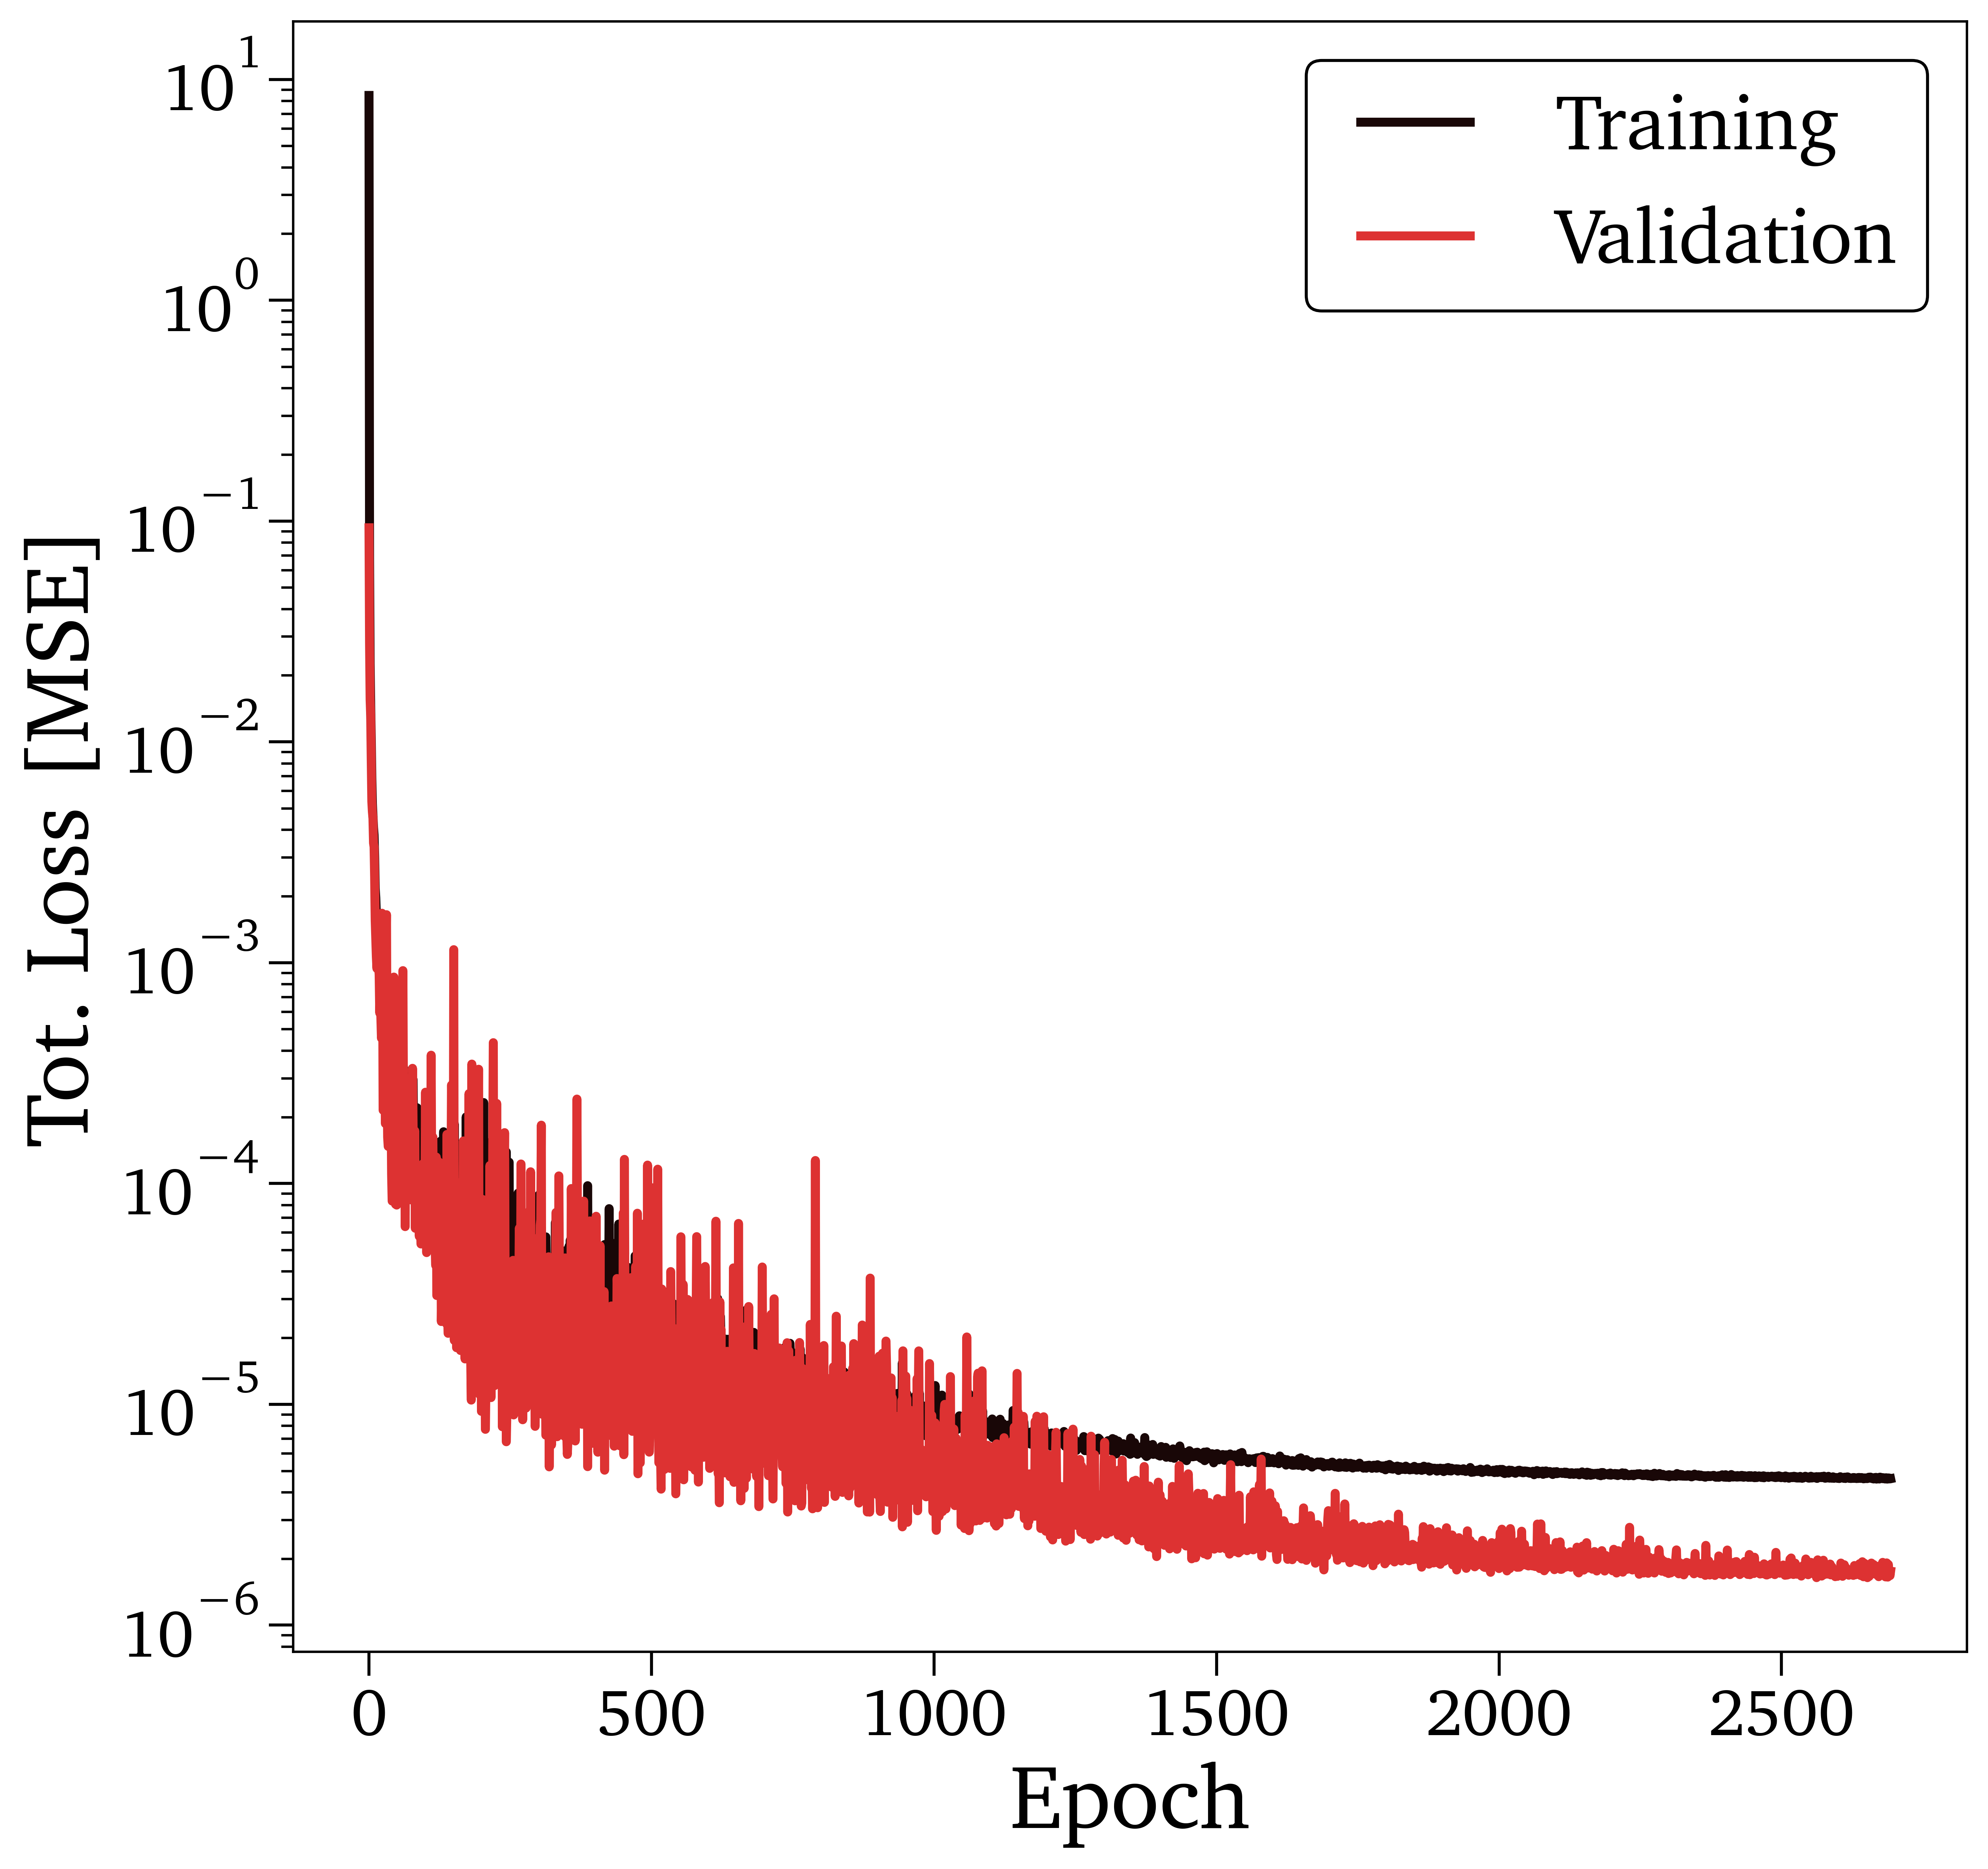

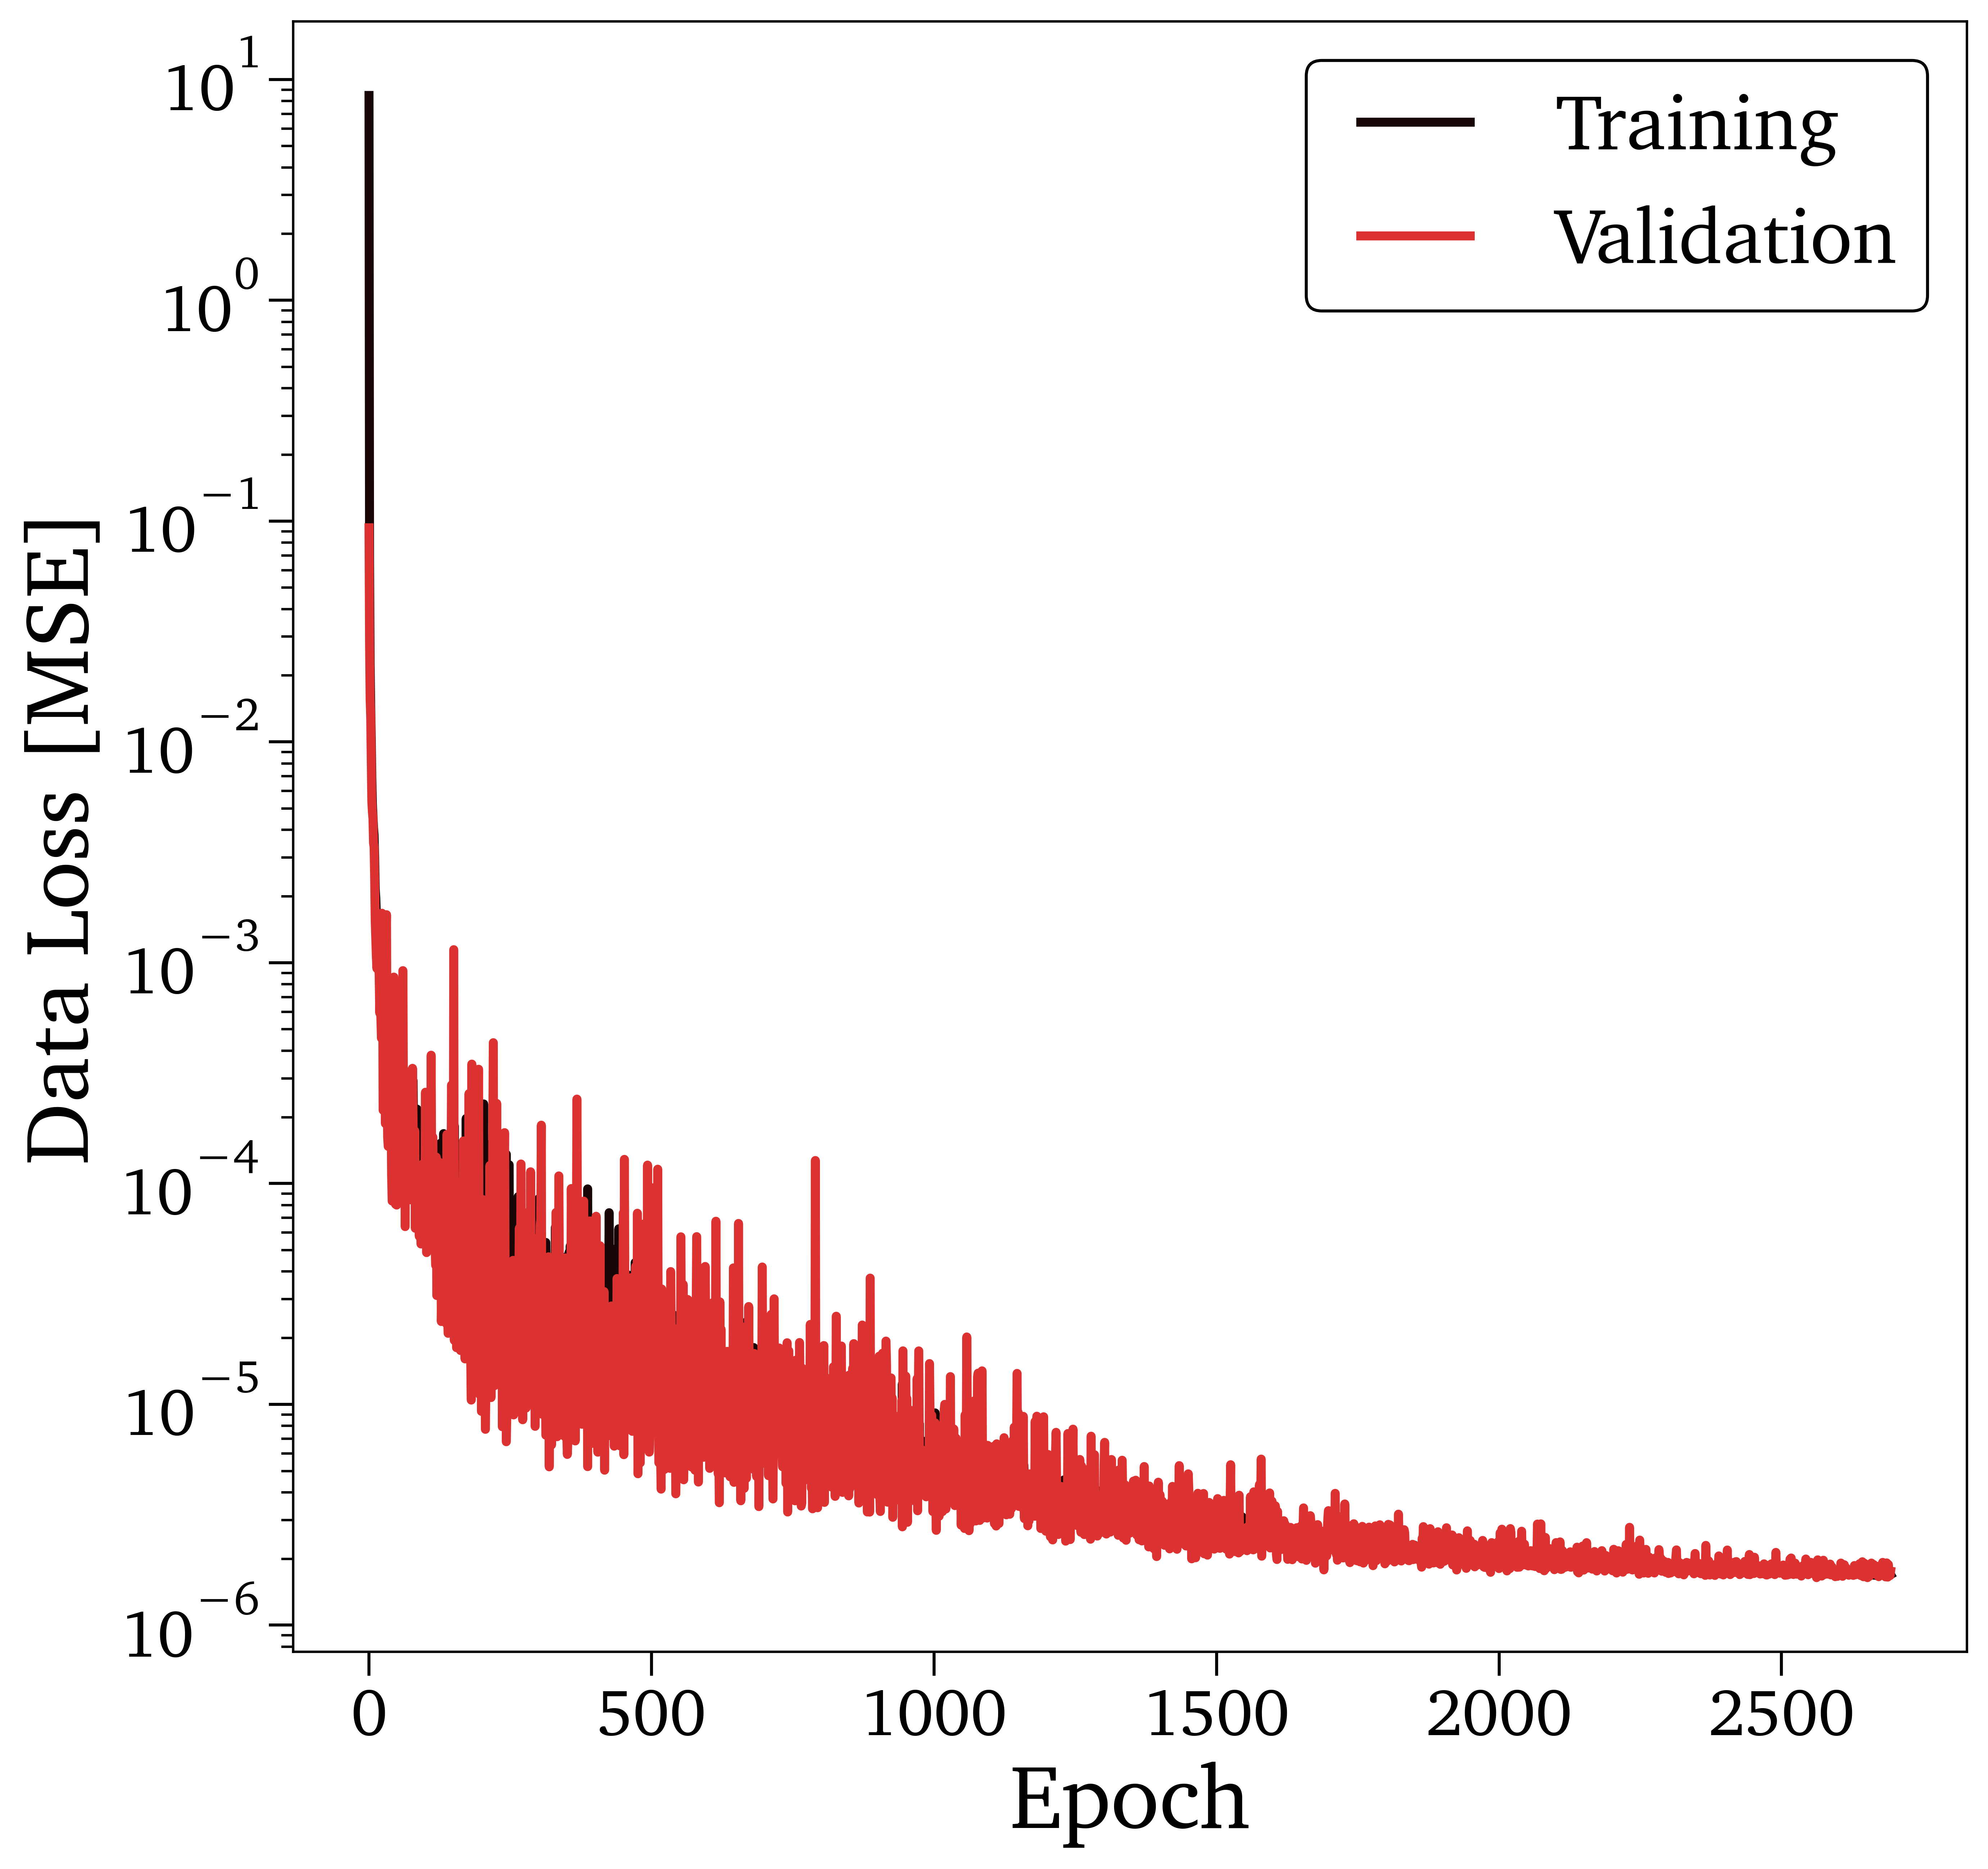

In [12]:
Data = pd.read_csv(path_to_run_fld+'/Training/History.csv')

fig  = plt.figure()
plt.plot(Data['tot_loss'],     label='Training')
plt.plot(Data['val_tot_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
plt.yscale('log')


fig  = plt.figure()
plt.plot(Data['pts_loss'],     label='Training')
plt.plot(Data['val_pts_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
plt.yscale('log')
#plt.ylim([1.e-2, 1.e0])

# fig  = plt.figure()
# plt.plot(Data['res_loss'],     label='Training')
# plt.plot(Data['val_res_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('Res Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure()
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

## Evaluating Branches' and Trunk's Outputs

In [13]:
# FileName   = InputData.path_to_data_fld + '/test/ext/Input.csv'# + InputData.InputFile
# DataIn     = pd.read_csv(FileName, header=0)
# Input_     = DataIn.to_numpy()
# VarNames   = list(DataIn.columns)

# FileName   = InputData.path_to_data_fld + '/test/ext/Output.csv'# + InputData.InputFile
# Data       = pd.read_csv(FileName, header=0)
# Output_    = Data.to_numpy()

In [14]:
FileName  = WORKSPACE_PATH + '/ROMNet/Data/TransTanh_100Cases/Orig/test/ext/Input.csv'# + InputData.InputFile
Data      = pd.read_csv(FileName, header=0)
Input     = Data[branch_vars].to_numpy()
VarNames  = list(Data.columns)
Nu        = Input.shape[1]
u         = []
for iu in range(Nu):
    u.append(np.unique(Input[:,iu]))
u         = np.stack(u, axis=0).T
n_test     = u.shape[0]


## Variable to Be Visualized
VarOI     = 'v'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break

iSim = 0
for iTest in range(n_test):#[0,1,2,3,4]:
    
#     ### Generating Data  
#     output     = solve_ivp( fOrig, tout[[0,-1]], u[iTest,:], method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
#     tOrig      = tout
#     yMatOrig   = output.y.T
    
    ### Creating NN Input
    tPred     = tOrig[...,np.newaxis]
    Nt        = len(tPred)
    uPred     = u[iTest,:]*np.ones((Nt,2))
    InputPred = np.concatenate((uPred,tPred), axis=1)

Text(0, 0.5, '$\\alpha_i$')

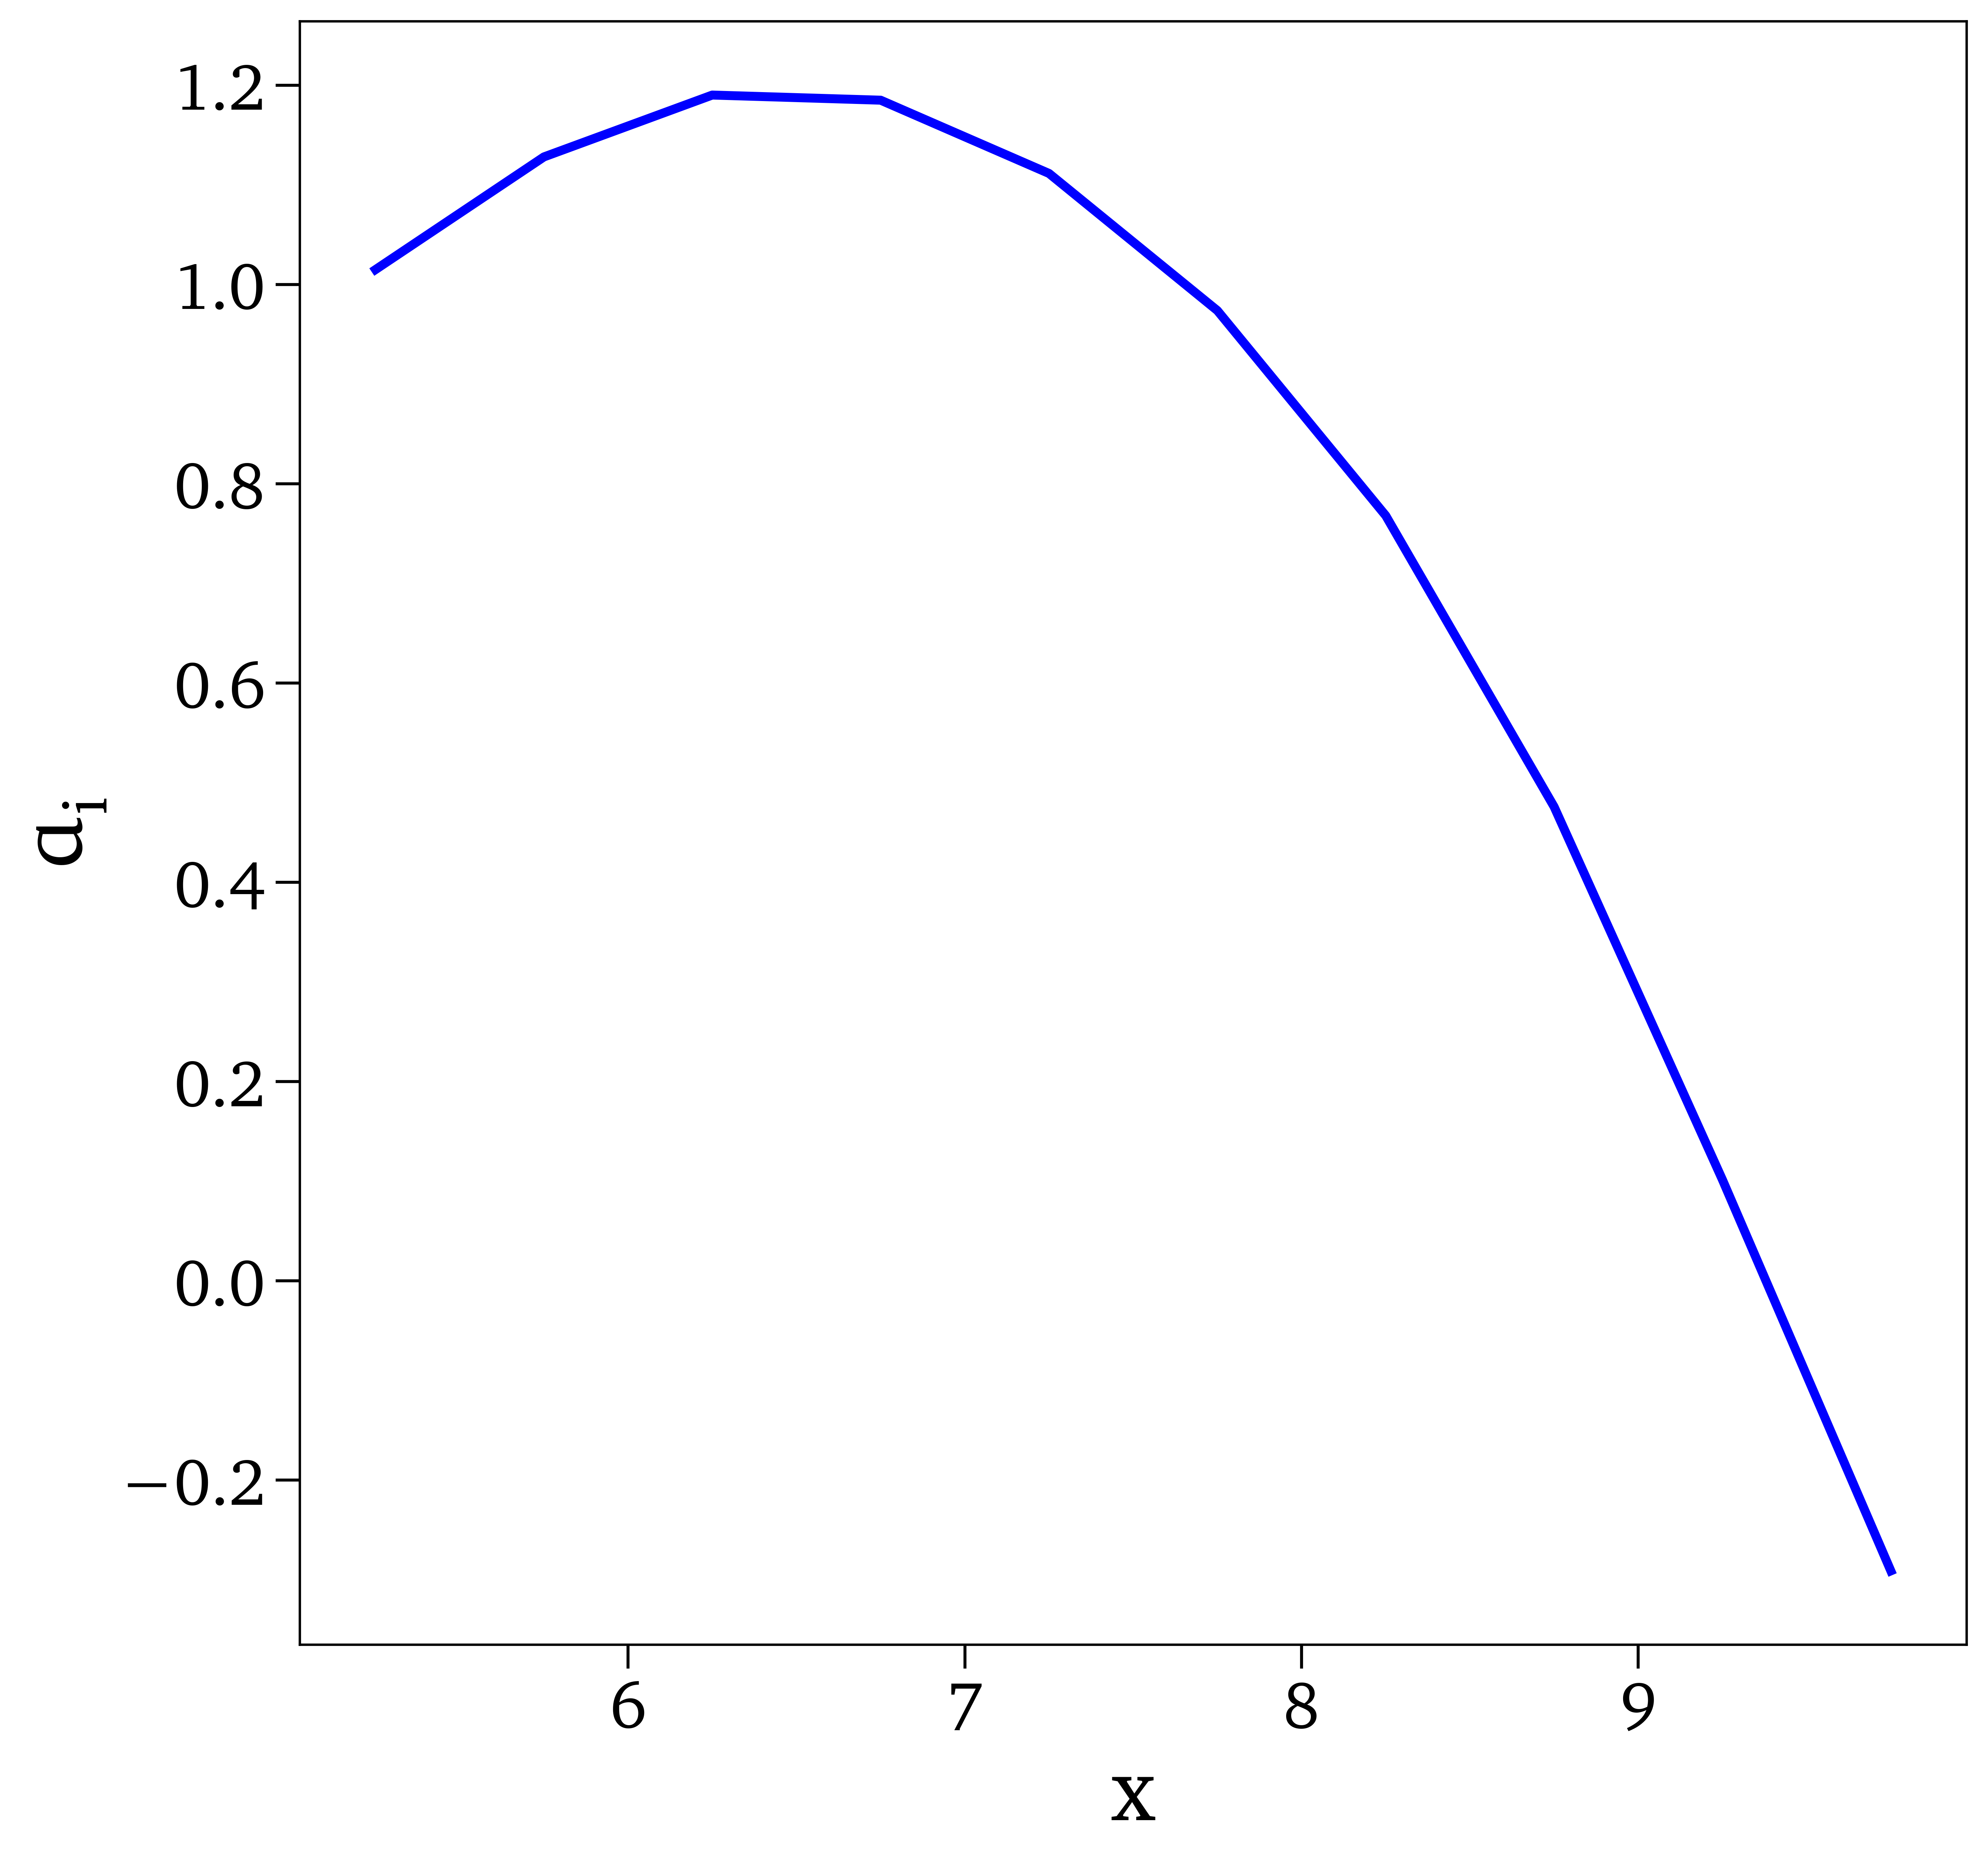

In [15]:
iVar     = 0

output_1 = model.net.system_of_components['DeepONet'].components['Branch'].call(u, model.net.layers_dict, None, training=False)

fig = plt.figure()
plt.plot(u[:,0], output_1[:,iVar], 'b-')
#plt.plot(u[:,0], u[:,1], output_1[:,1], 'b:')
#plt.xlim([1.e-6, 1.e-2])
plt.xlabel(r'x')
plt.ylabel(r'v')
plt.ylabel(r'$\alpha_i$')

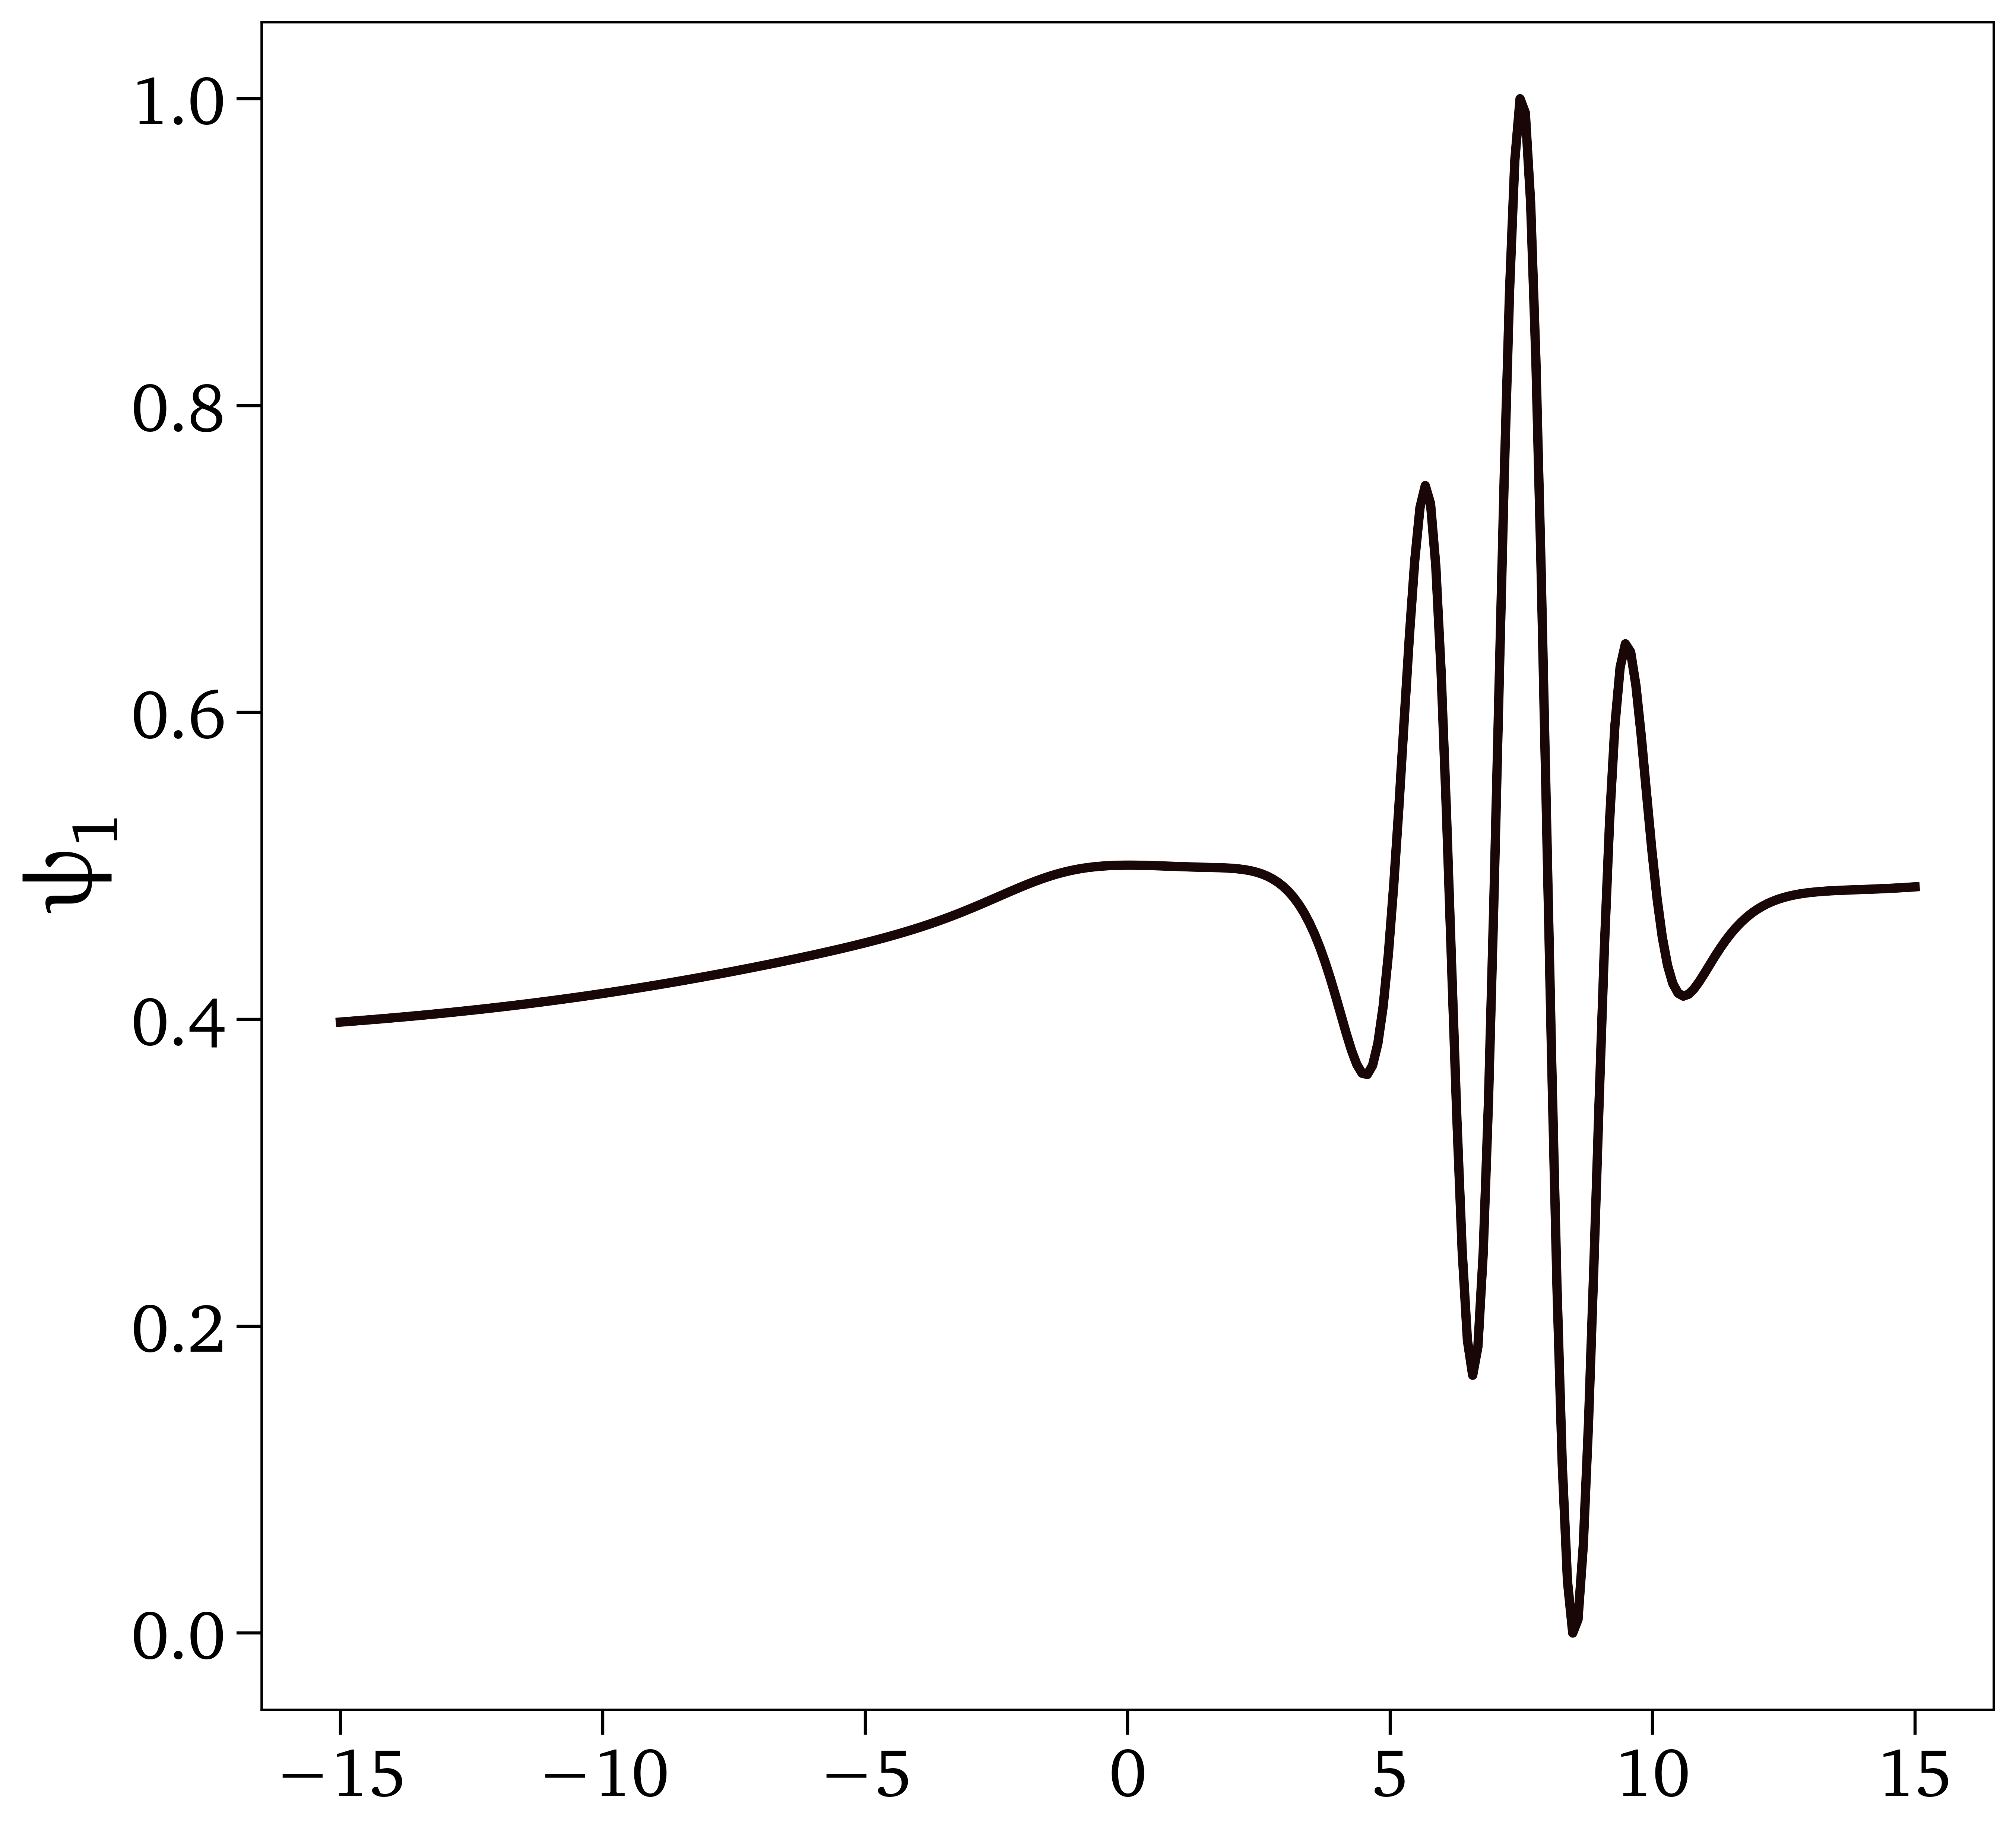

In [16]:
tVec         = np.linspace(-15,15,300)[...,np.newaxis]

output_trunk = model.net.system_of_components['DeepONet'].components['Trunk'].call(tVec, model.net.layers_dict, None, training=False)
output_trunk = np.array(output_trunk)



i   = 7

fig = plt.figure()
phi = (output_trunk[:,i] - output_trunk[:,i].min() ) / (output_trunk[:,i].max() - output_trunk[:,i].min())
plt.plot(tVec, phi)
plt.ylabel(r'$\psi_{1}}$')

if (FigDir):
    #plt.xlabel(r'$t$')
    #plt.savefig(FigDir+'/TransTanh_TrainedDynamics_PINN_'+str(InputData.n_modes)+'_phi.eps', format='eps', bbox_inches='tight')
    plt.xlabel(r'$t-\bar{t}$')
    plt.savefig(FigDir+'/TransTanh_TrainedDynamics_SVD_'+str(InputData.n_modes)+'_phi.eps', format='eps', bbox_inches='tight')
    pass

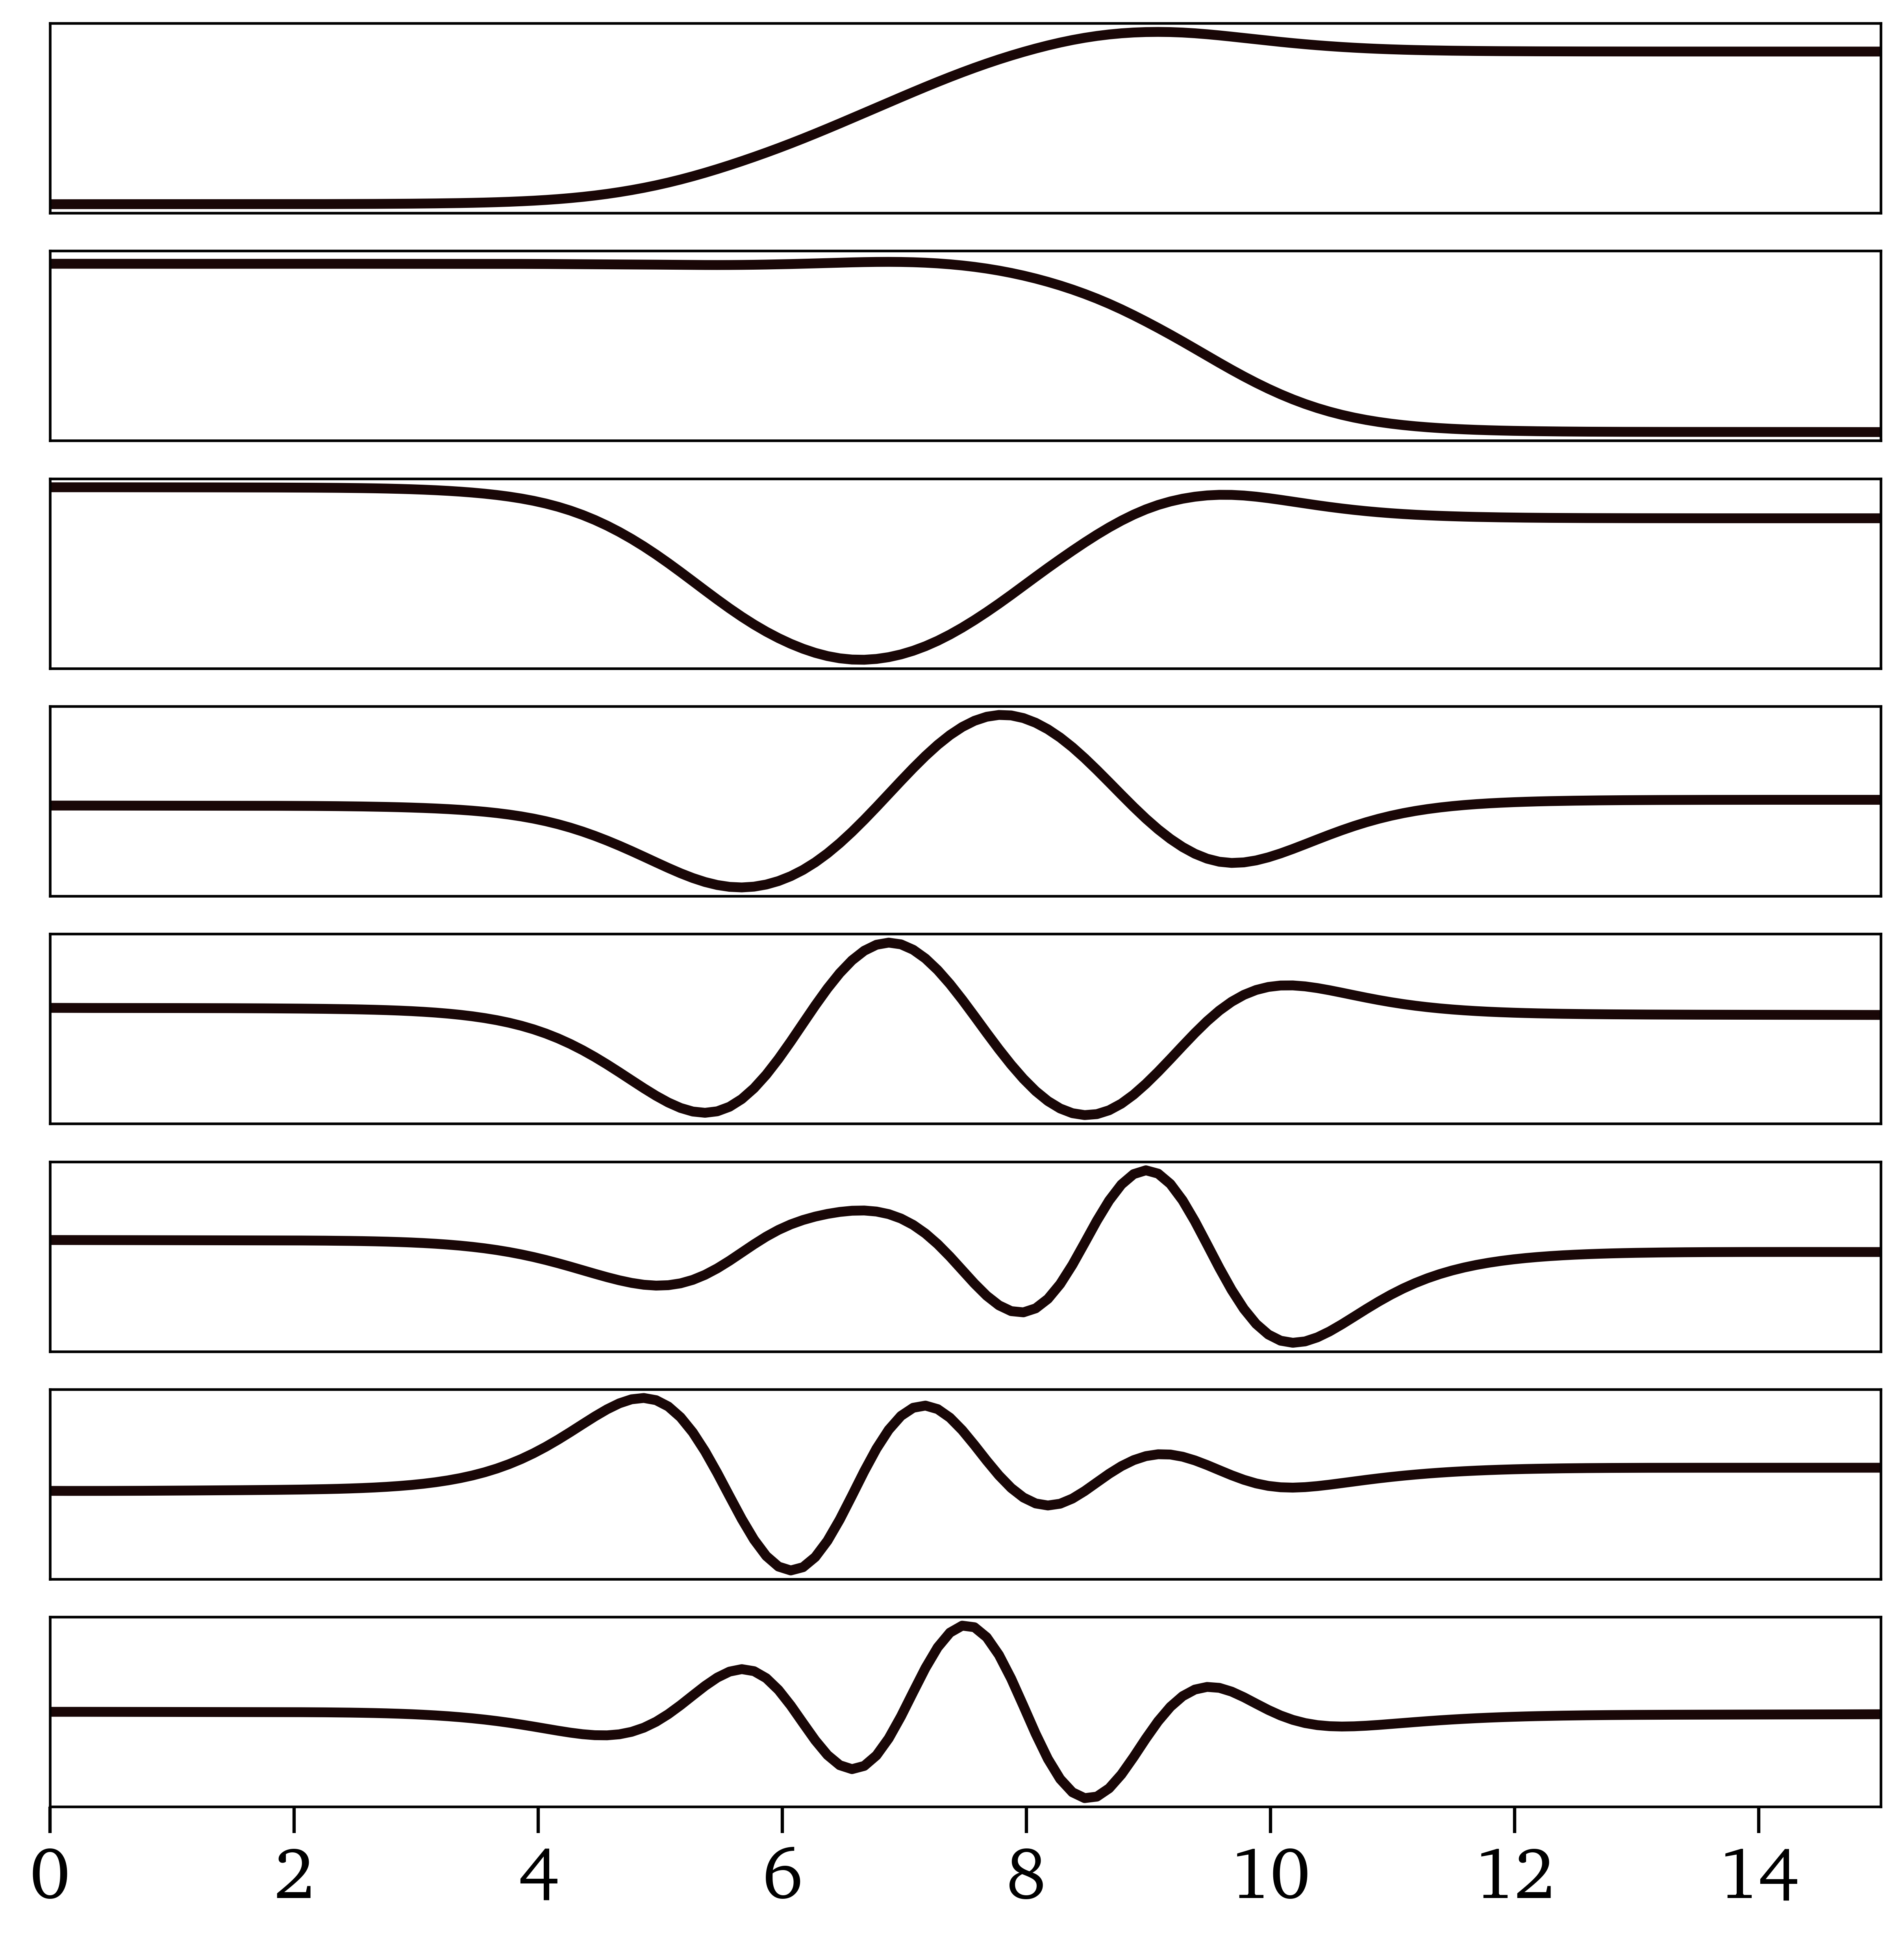

In [17]:
fig, (axVec) = plt.subplots(output_trunk.shape[1], 1)

for i in range(output_trunk.shape[1]):
    
    phi = (output_trunk[:,i] - output_trunk[:,i].min() ) / (output_trunk[:,i].max() - output_trunk[:,i].min())
    axVec[i].plot(tVec, phi)
    axVec[i].set_xlim([0., 15.])
    axVec[i].set_yticks([])
    if i<output_trunk.shape[1]-1:
        axVec[i].set_xticks([])
    plt.setp(axVec[i].get_yticklabels(), visible=False)

if (FigDir):
    #plt.savefig(FigDir+'/TransTanh_PINN_Trunk_Modes_'+str(InputData.n_modes)+'.eps', format='eps', bbox_inches='tight')
    #plt.savefig(FigDir+'/TransTanh_PCA_Trunk_Modes_'+str(InputData.n_modes)+'.eps', format='eps', bbox_inches='tight')
    pass

## Evaluating Rigid Block's Outputs

In [18]:
fig = plt.figure()


output_rigid = model.net.system_of_components['DeepONet'].components['Shift'].call(u, model.net.layers_dict, None, training=False)

output_rigid.shape

plt.scatter(u[:,0],  output_rigid[:,0], label=r'$\eta_{'+str(1)+'}$')


plt.xlabel(r'$x_0}$')
plt.ylabel(r'$\bar{t}$')
plt.legend()
#ax.set_zscale('log')

KeyError: 'Shift'

<Figure size 6000x6000 with 0 Axes>

In [ ]:
iTestVec = np.arange(10)


NewFlg   = True
fig, ax1 = plt.subplots()
ax2      = ax1.twiny()  # instantiate a second axes that shares the same x-axis
Params   = np.zeros(2)
for iTest in iTestVec:
    y0         = u[iTest,:]
    #print('y0 = ', y0)
    Params[0]  = u[iTest,:]
    Params[1]  = aParam
    
    print('u0 = ', u[iTest,:])

    ### Generating Data  
    output     = solve_ivp( fOrig, tout[[0,-1]], u[iTest,:], method=SOLVER, t_eval=tout, rtol=1.e-15, atol=1.e-10 )
    tOrig      = tout
    yMatOrig   = output.y.T
    

    if NewFlg:
        Label1 = 'ODE'
        Label2 = 'Rigid Block Prepr.'
        NewFlg = False
    else:
        Label1 = None
        Label2 = None

    ax1.plot(tOrig, yMatOrig, color=ColorVec[0], label=Label1, lw=2)

    ax2.plot(tOrig+output_rigid[iTest], yMatOrig, color=ColorVec[1], label=Label2, lw=2)

plt.vlines(0., ymin=5., ymax=12., linestyles='dashed', color=ColorVec[1])

color = ColorVec[0]
ax1.set_xlabel(r'$t$', size=34)
ax1.set_ylabel(r'$x$', color=color, size=34)
ax1.tick_params(axis='y', labelcolor=color)

color = ColorVec[1]
ax2.set_xlabel(r'$t-\bar{t}$', color=color, size=34)  # we already handled the x-label with ax1
#ax2.set_ylabel(r'$x$', color=color, size=34)
ax2.tick_params(axis='x', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

#plt.legend(loc=4)



if (FigDir):
    plt.savefig(FigDir+'/Tanh_TrainedDynamics_SVD_'+str(InputData.n_modes)+'_Shifted.eps', format='eps', bbox_inches='tight')
    pass